In [36]:
import glob
import numpy as np
import pandas as pd
import cv2
import random 
import math
import os
import sys
import ipynb
import importlib
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
from skimage import transform
from torch.autograd import Variable

sns.set(style='ticks', palette='Set2')

In [3]:
import ipynb.fs.full.BeeDataHandler as BeeDataHandler

In [4]:
importlib.reload(BeeDataHandler)

<module 'ipynb.fs.full.BeeDataHandler' (/Users/dieumynguyen/Documents/S2019_ObjectOrientedDesign/PyTorchPresentation/BeeHealthClassification_orig/BeeDataHandler.ipynb)>

### Parameters

In [5]:
IMG_SIZE = 32
BATCH_SIZE = 32
BW = False

bee_dir = '/Users/dieumynguyen/Datasets/HoneyBees'

### Define transformations for data augmentation

In [6]:
transform_list = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=180),
    transforms.RandomAffine(degrees=180, translate=(0, 0.2)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),  # Always need, div by 255 
    BeeDataHandler.CustomNormalize()
])

### Load data

In [7]:
# Wrapper around the data
# Could load data into np or a pointer/filepath
bee_data_src = BeeDataHandler.DataHandler(bee_dir, transforms=transform_list, bw=BW, test_split=0.2)

In [8]:
train_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.train_sampler)
test_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.test_sampler)

In [9]:
def sample_imgs():
    xxx = (X + 1) / 2.0
    grid_img = utils.make_grid(xxx)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(grid_img.permute(1,2,0))
    recovered_labels = [bee_data_src.idx_to_key[ele.item()] for ele in y]
    title_str = ""
    for recovered_label in recovered_labels:
        title_str += f"{recovered_label}                     "
    title_str = title_str[:-3]
    plt.title(title_str)

### CNN

$$ out = \frac{in - k + 2*P}{stride} + 1$$

$$ in = [(in - k + 2P) / S] + 1$$ 
$$ P = (S(in - 1) - in + k ) / 2$$ 
$$ P = (S*in - S - in + k ) / 2$$ 
$$ P = (in(S - 1) - S + k ) / 2$$ 

if S == 1:
$$ P = (k-S) / 2$$ 

In [10]:
def calculate_padding_for_SAME(in_size, k_size, stride=1):
    padding = (in_size * ( stride - 1) - stride + k_size) / 2 
    return int(padding)

In [11]:
def calculate_output_dimension(in_size, k_size, padding, stride=1):
    out_size = int(np.floor((in_size - k_size + 2*padding)/stride)) + 1
    return out_size

In [12]:
class CNN(nn.Module):
    
    def __init__(self, num_classes, num_in_channels, input_dim=IMG_SIZE):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super(CNN, self).__init__()
        
        num_kernels = [5, 10, 50]
        k_sizes = [3, 3, 3]
        
        
        """ CONV LAYER 1 """
        """ ---------------------------------------- """
        padding_1 = calculate_padding_for_SAME(input_dim, k_size=k_sizes[0])     
        print("padding_1: ", padding_1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_kernels[0], kernel_size=k_sizes[0], padding=padding_1),
            nn.BatchNorm2d(num_kernels[0]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        nn.init.xavier_uniform_(self.layer1[0].weight)
        
        output_dim_layer_1 = calculate_output_dimension(input_dim, k_sizes[0], padding=padding_1)
        output_dim_layer_1 = output_dim_layer_1 // 2
        print("output_dim_layer_1: ", output_dim_layer_1)
        """ ---------------------------------------- """
        
        """ CONV LAYER 2 """
        """ ---------------------------------------- """
        padding_2 = calculate_padding_for_SAME(output_dim_layer_1, k_size=k_sizes[1])
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_kernels[0], num_kernels[1], kernel_size=k_sizes[1], padding=padding_2),  
            nn.BatchNorm2d(num_kernels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        nn.init.xavier_uniform_(self.layer2[0].weight)
        
        output_dim_layer_2 = calculate_output_dimension(output_dim_layer_1, k_sizes[1], padding=padding_2)
        output_dim_layer_2 = output_dim_layer_2 // 2
        print("output_dim_layer_2: ", output_dim_layer_2)
        """ ---------------------------------------- """
        
        """ CONV LAYER 3 """
        """ ---------------------------------------- """
        padding_3 = calculate_padding_for_SAME(output_dim_layer_2, k_size=k_sizes[2])        
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_kernels[1], num_kernels[2], kernel_size=k_sizes[2], padding=padding_3),  
            nn.BatchNorm2d(num_kernels[2]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        nn.init.xavier_uniform_(self.layer3[0].weight)
        
        output_dim_layer_3 = calculate_output_dimension(output_dim_layer_2, k_sizes[2], padding=padding_3)
        output_dim_layer_3 = output_dim_layer_3 // 2
        print("output_dim_layer_3: ", output_dim_layer_3)
        """ ---------------------------------------- """
        
        
        """ FULLY CONNECTED """
        """ ---------------------------------------- """
        flat_shape = num_kernels[2] * output_dim_layer_3 * output_dim_layer_3 
        
        self.fc = nn.Sequential(
            nn.Linear(flat_shape, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(100, num_classes)
        )
        """ ---------------------------------------- """
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Flatten
        out = out.view(out.size(0), -1) 
        
        # Fully Connected
        out = self.fc(out)
        
        return out
        

In [13]:
num_epochs = 1000
learning_rate = 0.0005

# Instantiate an instance of the conv net
num_classes = bee_data_src.num_classes
num_in_channels = 1 if BW else 3
net = CNN(num_classes=num_classes, num_in_channels=num_in_channels)

# Loss function and optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

losses = []
test_accuracies = []
train_accuracies = []

padding_1:  1
output_dim_layer_1:  16
output_dim_layer_2:  8
output_dim_layer_3:  4


### Train

In [14]:
def evaluate_model(dataset_key):
    net.eval()
    correct = 0
    total = 0
    data_loader = train_dataloader if dataset_key == 'train' else test_dataloader
    for images, labels in data_loader:
        outputs = net(images)
        predicted_vals, predicted_idxs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted_idxs == labels).sum()

    accuracy = 100 * correct / float(total)
    print(f"\n{dataset_key.capitalize()} accuracy: {accuracy:0.2f}%")
    return accuracy

In [15]:
try:
    for epoch_i in range(num_epochs):
        net.train()
        batch_losses = []
        for batch_i, (images, labels) in enumerate(train_dataloader):

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add loss values to array to print out progress of training
            batch_losses.append(loss.data) 

            if (batch_i+1) % 50 == 0:
                num_batches = len(train_dataloader)
                
                if losses == []:
                    epoch_loss_val = 9999
                else:
                    epoch_loss_val = losses[-1]
                batch_loss_val = np.mean(batch_losses)
                print_str = f'\rEpoch: {epoch_i+1}/{num_epochs} -- '
                print_str += f'Epoch Loss: {epoch_loss_val:0.4f} -- '
                print_str += f'Batch: {batch_i+1}/{num_batches} -- '
                print_str += f'Batch Loss: {batch_loss_val:0.4f}'
                
                sys.stdout.write(print_str)
                sys.stdout.flush()
                

        if epoch_i % 1 == 0:
            train_acc = evaluate_model('train')
            train_accuracies.append((epoch_i, train_acc))
            
            test_acc = evaluate_model('test')
            test_accuracies.append((epoch_i, test_acc))
            
        losses.append(np.mean(batch_losses))
except KeyboardInterrupt:
    print("\nEnding Early.")

Epoch: 1/1000 -- Epoch Loss: 9999.0000 -- Batch: 100/130 -- Batch Loss: 1.1431
Train accuracy: 65.00%

Test accuracy: 65.00%
Epoch: 2/1000 -- Epoch Loss: 1.0922 -- Batch: 100/130 -- Batch Loss: 0.7942
Train accuracy: 74.00%

Test accuracy: 77.00%
Epoch: 3/1000 -- Epoch Loss: 0.7845 -- Batch: 100/130 -- Batch Loss: 0.6358
Train accuracy: 77.00%

Test accuracy: 78.00%
Epoch: 4/1000 -- Epoch Loss: 0.6118 -- Batch: 100/130 -- Batch Loss: 0.5469
Train accuracy: 79.00%

Test accuracy: 81.00%
Epoch: 5/1000 -- Epoch Loss: 0.5509 -- Batch: 100/130 -- Batch Loss: 0.5250
Train accuracy: 80.00%

Test accuracy: 82.00%
Epoch: 6/1000 -- Epoch Loss: 0.5138 -- Batch: 100/130 -- Batch Loss: 0.4833
Train accuracy: 82.00%

Test accuracy: 82.00%
Epoch: 7/1000 -- Epoch Loss: 0.4693 -- Batch: 100/130 -- Batch Loss: 0.4448
Train accuracy: 81.00%

Test accuracy: 82.00%
Epoch: 8/1000 -- Epoch Loss: 0.4439 -- Batch: 100/130 -- Batch Loss: 0.4466
Train accuracy: 82.00%

Test accuracy: 83.00%
Epoch: 9/1000 -- Epoc


Test accuracy: 91.00%
Epoch: 68/1000 -- Epoch Loss: 0.2019 -- Batch: 100/130 -- Batch Loss: 0.1898
Train accuracy: 91.00%

Test accuracy: 91.00%
Epoch: 69/1000 -- Epoch Loss: 0.1917 -- Batch: 100/130 -- Batch Loss: 0.2055
Train accuracy: 92.00%

Test accuracy: 91.00%
Epoch: 70/1000 -- Epoch Loss: 0.2064 -- Batch: 100/130 -- Batch Loss: 0.1777
Train accuracy: 91.00%

Test accuracy: 91.00%
Epoch: 71/1000 -- Epoch Loss: 0.1791 -- Batch: 100/130 -- Batch Loss: 0.1821
Train accuracy: 93.00%

Test accuracy: 92.00%
Epoch: 72/1000 -- Epoch Loss: 0.1819 -- Batch: 100/130 -- Batch Loss: 0.1772
Train accuracy: 92.00%

Test accuracy: 91.00%
Epoch: 73/1000 -- Epoch Loss: 0.1767 -- Batch: 100/130 -- Batch Loss: 0.1719
Train accuracy: 92.00%

Test accuracy: 91.00%
Epoch: 74/1000 -- Epoch Loss: 0.1716 -- Batch: 100/130 -- Batch Loss: 0.1806
Train accuracy: 93.00%

Test accuracy: 93.00%
Epoch: 75/1000 -- Epoch Loss: 0.1799 -- Batch: 100/130 -- Batch Loss: 0.1656
Train accuracy: 93.00%

Test accuracy: 

Epoch: 134/1000 -- Epoch Loss: 0.1456 -- Batch: 100/130 -- Batch Loss: 0.1454
Train accuracy: 94.00%

Test accuracy: 92.00%
Epoch: 135/1000 -- Epoch Loss: 0.1445 -- Batch: 100/130 -- Batch Loss: 0.1269
Train accuracy: 94.00%

Test accuracy: 94.00%
Epoch: 136/1000 -- Epoch Loss: 0.1310 -- Batch: 100/130 -- Batch Loss: 0.1504
Train accuracy: 94.00%

Test accuracy: 93.00%
Epoch: 137/1000 -- Epoch Loss: 0.1521 -- Batch: 100/130 -- Batch Loss: 0.1354
Train accuracy: 94.00%

Test accuracy: 93.00%
Epoch: 138/1000 -- Epoch Loss: 0.1373 -- Batch: 100/130 -- Batch Loss: 0.1385
Train accuracy: 92.00%

Test accuracy: 90.00%
Epoch: 139/1000 -- Epoch Loss: 0.1516 -- Batch: 100/130 -- Batch Loss: 0.1614
Train accuracy: 94.00%

Test accuracy: 95.00%
Epoch: 140/1000 -- Epoch Loss: 0.1572 -- Batch: 100/130 -- Batch Loss: 0.1256
Train accuracy: 94.00%

Test accuracy: 94.00%
Epoch: 141/1000 -- Epoch Loss: 0.1360 -- Batch: 100/130 -- Batch Loss: 0.1578
Train accuracy: 94.00%

Test accuracy: 94.00%
Epoch: 1

Epoch: 200/1000 -- Epoch Loss: 0.1222 -- Batch: 100/130 -- Batch Loss: 0.1231
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 201/1000 -- Epoch Loss: 0.1260 -- Batch: 100/130 -- Batch Loss: 0.1159
Train accuracy: 95.00%

Test accuracy: 95.00%
Epoch: 202/1000 -- Epoch Loss: 0.1138 -- Batch: 100/130 -- Batch Loss: 0.1192
Train accuracy: 95.00%

Test accuracy: 95.00%
Epoch: 203/1000 -- Epoch Loss: 0.1252 -- Batch: 100/130 -- Batch Loss: 0.1295
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 204/1000 -- Epoch Loss: 0.1274 -- Batch: 100/130 -- Batch Loss: 0.1276
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 205/1000 -- Epoch Loss: 0.1222 -- Batch: 100/130 -- Batch Loss: 0.1246
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 206/1000 -- Epoch Loss: 0.1269 -- Batch: 100/130 -- Batch Loss: 0.1168
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 207/1000 -- Epoch Loss: 0.1226 -- Batch: 100/130 -- Batch Loss: 0.1287
Train accuracy: 95.00%

Test accuracy: 93.00%
Epoch: 2

Epoch: 266/1000 -- Epoch Loss: 0.1207 -- Batch: 100/130 -- Batch Loss: 0.1079
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 267/1000 -- Epoch Loss: 0.1217 -- Batch: 100/130 -- Batch Loss: 0.1696
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 268/1000 -- Epoch Loss: 0.1597 -- Batch: 100/130 -- Batch Loss: 0.1207
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 269/1000 -- Epoch Loss: 0.1229 -- Batch: 100/130 -- Batch Loss: 0.1151
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 270/1000 -- Epoch Loss: 0.1222 -- Batch: 100/130 -- Batch Loss: 0.1176
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 271/1000 -- Epoch Loss: 0.1173 -- Batch: 100/130 -- Batch Loss: 0.1191
Train accuracy: 95.00%

Test accuracy: 95.00%
Epoch: 272/1000 -- Epoch Loss: 0.1153 -- Batch: 100/130 -- Batch Loss: 0.1211
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 273/1000 -- Epoch Loss: 0.1207 -- Batch: 100/130 -- Batch Loss: 0.1203
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 2

Epoch: 332/1000 -- Epoch Loss: 0.1195 -- Batch: 100/130 -- Batch Loss: 0.1183
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 333/1000 -- Epoch Loss: 0.1154 -- Batch: 100/130 -- Batch Loss: 0.1119
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 334/1000 -- Epoch Loss: 0.1144 -- Batch: 100/130 -- Batch Loss: 0.1112
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 335/1000 -- Epoch Loss: 0.1117 -- Batch: 100/130 -- Batch Loss: 0.1044
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 336/1000 -- Epoch Loss: 0.1089 -- Batch: 100/130 -- Batch Loss: 0.1043
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 337/1000 -- Epoch Loss: 0.1119 -- Batch: 100/130 -- Batch Loss: 0.1111
Train accuracy: 95.00%

Test accuracy: 95.00%
Epoch: 338/1000 -- Epoch Loss: 0.1128 -- Batch: 100/130 -- Batch Loss: 0.1107
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 339/1000 -- Epoch Loss: 0.1057 -- Batch: 100/130 -- Batch Loss: 0.1126
Train accuracy: 95.00%

Test accuracy: 94.00%
Epoch: 3

Epoch: 398/1000 -- Epoch Loss: 0.0986 -- Batch: 100/130 -- Batch Loss: 0.0934
Train accuracy: 96.00%

Test accuracy: 96.00%
Epoch: 399/1000 -- Epoch Loss: 0.0957 -- Batch: 100/130 -- Batch Loss: 0.1016
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 400/1000 -- Epoch Loss: 0.1042 -- Batch: 100/130 -- Batch Loss: 0.1008
Train accuracy: 96.00%

Test accuracy: 96.00%
Epoch: 401/1000 -- Epoch Loss: 0.0999 -- Batch: 100/130 -- Batch Loss: 0.1094
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 402/1000 -- Epoch Loss: 0.1073 -- Batch: 100/130 -- Batch Loss: 0.1065
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 403/1000 -- Epoch Loss: 0.1021 -- Batch: 100/130 -- Batch Loss: 0.1177
Train accuracy: 96.00%

Test accuracy: 96.00%
Epoch: 404/1000 -- Epoch Loss: 0.1083 -- Batch: 100/130 -- Batch Loss: 0.1003
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 405/1000 -- Epoch Loss: 0.1017 -- Batch: 100/130 -- Batch Loss: 0.0958
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 4

Epoch: 464/1000 -- Epoch Loss: 0.1071 -- Batch: 100/130 -- Batch Loss: 0.0924
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 465/1000 -- Epoch Loss: 0.0937 -- Batch: 100/130 -- Batch Loss: 0.0979
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 466/1000 -- Epoch Loss: 0.1018 -- Batch: 100/130 -- Batch Loss: 0.0873
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 467/1000 -- Epoch Loss: 0.0925 -- Batch: 100/130 -- Batch Loss: 0.0868
Train accuracy: 97.00%

Test accuracy: 94.00%
Epoch: 468/1000 -- Epoch Loss: 0.0928 -- Batch: 100/130 -- Batch Loss: 0.0940
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 469/1000 -- Epoch Loss: 0.1010 -- Batch: 100/130 -- Batch Loss: 0.1022
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 470/1000 -- Epoch Loss: 0.0978 -- Batch: 100/130 -- Batch Loss: 0.1078
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 471/1000 -- Epoch Loss: 0.1036 -- Batch: 100/130 -- Batch Loss: 0.0904
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 4

Epoch: 530/1000 -- Epoch Loss: 0.0814 -- Batch: 100/130 -- Batch Loss: 0.1046
Train accuracy: 96.00%

Test accuracy: 96.00%
Epoch: 531/1000 -- Epoch Loss: 0.0992 -- Batch: 100/130 -- Batch Loss: 0.0864
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 532/1000 -- Epoch Loss: 0.0898 -- Batch: 100/130 -- Batch Loss: 0.1014
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 533/1000 -- Epoch Loss: 0.1053 -- Batch: 100/130 -- Batch Loss: 0.0905
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 534/1000 -- Epoch Loss: 0.0913 -- Batch: 100/130 -- Batch Loss: 0.0893
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 535/1000 -- Epoch Loss: 0.0926 -- Batch: 100/130 -- Batch Loss: 0.0936
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 536/1000 -- Epoch Loss: 0.0938 -- Batch: 100/130 -- Batch Loss: 0.1005
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 537/1000 -- Epoch Loss: 0.1051 -- Batch: 100/130 -- Batch Loss: 0.0976
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 5

Epoch: 596/1000 -- Epoch Loss: 0.0913 -- Batch: 100/130 -- Batch Loss: 0.1040
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 597/1000 -- Epoch Loss: 0.0968 -- Batch: 100/130 -- Batch Loss: 0.0983
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 598/1000 -- Epoch Loss: 0.0990 -- Batch: 100/130 -- Batch Loss: 0.0872
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 599/1000 -- Epoch Loss: 0.0889 -- Batch: 100/130 -- Batch Loss: 0.0870
Train accuracy: 96.00%

Test accuracy: 96.00%
Epoch: 600/1000 -- Epoch Loss: 0.0864 -- Batch: 100/130 -- Batch Loss: 0.0806
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 601/1000 -- Epoch Loss: 0.0809 -- Batch: 100/130 -- Batch Loss: 0.0822
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 602/1000 -- Epoch Loss: 0.0806 -- Batch: 100/130 -- Batch Loss: 0.0806
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 603/1000 -- Epoch Loss: 0.0873 -- Batch: 100/130 -- Batch Loss: 0.0846
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 6

Epoch: 662/1000 -- Epoch Loss: 0.0865 -- Batch: 100/130 -- Batch Loss: 0.0797
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 663/1000 -- Epoch Loss: 0.0786 -- Batch: 100/130 -- Batch Loss: 0.0825
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 664/1000 -- Epoch Loss: 0.0816 -- Batch: 100/130 -- Batch Loss: 0.0846
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 665/1000 -- Epoch Loss: 0.0821 -- Batch: 100/130 -- Batch Loss: 0.0754
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 666/1000 -- Epoch Loss: 0.0766 -- Batch: 100/130 -- Batch Loss: 0.0977
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 667/1000 -- Epoch Loss: 0.0964 -- Batch: 100/130 -- Batch Loss: 0.0792
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 668/1000 -- Epoch Loss: 0.0783 -- Batch: 100/130 -- Batch Loss: 0.0824
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 669/1000 -- Epoch Loss: 0.0813 -- Batch: 100/130 -- Batch Loss: 0.0958
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 6

Epoch: 728/1000 -- Epoch Loss: 0.0932 -- Batch: 100/130 -- Batch Loss: 0.0793
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 729/1000 -- Epoch Loss: 0.0791 -- Batch: 100/130 -- Batch Loss: 0.0771
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 730/1000 -- Epoch Loss: 0.0804 -- Batch: 100/130 -- Batch Loss: 0.0828
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 731/1000 -- Epoch Loss: 0.0829 -- Batch: 100/130 -- Batch Loss: 0.0799
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 732/1000 -- Epoch Loss: 0.0822 -- Batch: 100/130 -- Batch Loss: 0.0747
Train accuracy: 97.00%

Test accuracy: 94.00%
Epoch: 733/1000 -- Epoch Loss: 0.0767 -- Batch: 100/130 -- Batch Loss: 0.0873
Train accuracy: 96.00%

Test accuracy: 95.00%
Epoch: 734/1000 -- Epoch Loss: 0.0976 -- Batch: 100/130 -- Batch Loss: 0.0961
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 735/1000 -- Epoch Loss: 0.0934 -- Batch: 100/130 -- Batch Loss: 0.0860
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 7

Epoch: 794/1000 -- Epoch Loss: 0.0803 -- Batch: 100/130 -- Batch Loss: 0.0718
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 795/1000 -- Epoch Loss: 0.0733 -- Batch: 100/130 -- Batch Loss: 0.0850
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 796/1000 -- Epoch Loss: 0.0816 -- Batch: 100/130 -- Batch Loss: 0.0729
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 797/1000 -- Epoch Loss: 0.0742 -- Batch: 100/130 -- Batch Loss: 0.0870
Train accuracy: 96.00%

Test accuracy: 94.00%
Epoch: 798/1000 -- Epoch Loss: 0.0872 -- Batch: 100/130 -- Batch Loss: 0.0790
Train accuracy: 97.00%

Test accuracy: 94.00%
Epoch: 799/1000 -- Epoch Loss: 0.0776 -- Batch: 100/130 -- Batch Loss: 0.0810
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 800/1000 -- Epoch Loss: 0.0832 -- Batch: 100/130 -- Batch Loss: 0.0772
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 801/1000 -- Epoch Loss: 0.0760 -- Batch: 100/130 -- Batch Loss: 0.0705
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 8

Epoch: 860/1000 -- Epoch Loss: 0.0749 -- Batch: 100/130 -- Batch Loss: 0.0730
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 861/1000 -- Epoch Loss: 0.0815 -- Batch: 100/130 -- Batch Loss: 0.0856
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 862/1000 -- Epoch Loss: 0.0797 -- Batch: 100/130 -- Batch Loss: 0.0723
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 863/1000 -- Epoch Loss: 0.0727 -- Batch: 100/130 -- Batch Loss: 0.0872
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 864/1000 -- Epoch Loss: 0.0887 -- Batch: 100/130 -- Batch Loss: 0.0854
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 865/1000 -- Epoch Loss: 0.0867 -- Batch: 100/130 -- Batch Loss: 0.0844
Train accuracy: 97.00%

Test accuracy: 94.00%
Epoch: 866/1000 -- Epoch Loss: 0.0881 -- Batch: 100/130 -- Batch Loss: 0.0884
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 867/1000 -- Epoch Loss: 0.0841 -- Batch: 100/130 -- Batch Loss: 0.0785
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 8

Epoch: 926/1000 -- Epoch Loss: 0.0853 -- Batch: 100/130 -- Batch Loss: 0.0786
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 927/1000 -- Epoch Loss: 0.0820 -- Batch: 100/130 -- Batch Loss: 0.0825
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 928/1000 -- Epoch Loss: 0.0798 -- Batch: 100/130 -- Batch Loss: 0.0715
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 929/1000 -- Epoch Loss: 0.0760 -- Batch: 100/130 -- Batch Loss: 0.0648
Train accuracy: 97.00%

Test accuracy: 94.00%
Epoch: 930/1000 -- Epoch Loss: 0.0682 -- Batch: 100/130 -- Batch Loss: 0.0715
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 931/1000 -- Epoch Loss: 0.0768 -- Batch: 100/130 -- Batch Loss: 0.0575
Train accuracy: 97.00%

Test accuracy: 96.00%
Epoch: 932/1000 -- Epoch Loss: 0.0635 -- Batch: 100/130 -- Batch Loss: 0.0795
Train accuracy: 98.00%

Test accuracy: 94.00%
Epoch: 933/1000 -- Epoch Loss: 0.0776 -- Batch: 100/130 -- Batch Loss: 0.0727
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 9

Epoch: 992/1000 -- Epoch Loss: 0.0821 -- Batch: 100/130 -- Batch Loss: 0.0804
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 993/1000 -- Epoch Loss: 0.0814 -- Batch: 100/130 -- Batch Loss: 0.0654
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 994/1000 -- Epoch Loss: 0.0669 -- Batch: 100/130 -- Batch Loss: 0.0695
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 995/1000 -- Epoch Loss: 0.0702 -- Batch: 100/130 -- Batch Loss: 0.0675
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 996/1000 -- Epoch Loss: 0.0721 -- Batch: 100/130 -- Batch Loss: 0.0754
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 997/1000 -- Epoch Loss: 0.0743 -- Batch: 100/130 -- Batch Loss: 0.0708
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 998/1000 -- Epoch Loss: 0.0732 -- Batch: 100/130 -- Batch Loss: 0.0802
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 999/1000 -- Epoch Loss: 0.0793 -- Batch: 100/130 -- Batch Loss: 0.0606
Train accuracy: 97.00%

Test accuracy: 95.00%
Epoch: 1

In [24]:
with open("train_accs.txt", "w") as outfile:
    outfile.write(str(train_accs))

In [25]:
with open("test_accs.txt", "w") as outfile:
    outfile.write(str(test_accs))

In [26]:
np.save("train_accs.npy", train_accs)

In [27]:
np.save("test_accs.npy", test_accs)

In [62]:
max_acc = np.max(test_accs, 0)[1]
min_acc = np.min(test_accs, 0)[1]
max_acc, min_acc

(97, 65)

In [34]:
train_accs = np.array(train_accuracies)
test_accs = np.array(test_accuracies)

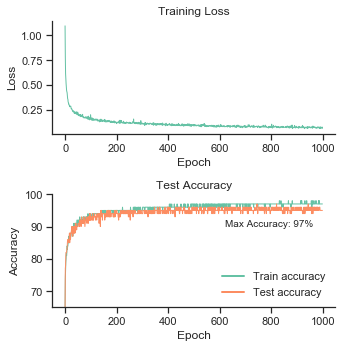

In [73]:
line_width = 1

## Trained model analysis and evaluation
f, ax = plt.subplots(2,1, figsize=(5,5))
ax[0].plot(losses, label="Train loss", linewidth=line_width)
# ax[0].plot(training.history['val_loss'], label="Validation loss", linewidth=line_width)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
# leg0 = ax[0].legend()
# for line in leg0.get_lines():
#     line.set_linewidth(2)

# Hide the right and top spines
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

# Accuracy
ax[1].plot(train_accs[:,1], label="Train accuracy", linewidth=line_width)
ax[1].plot(test_accs[:,1], label="Test accuracy", linewidth=line_width)
ax[1].set_title('Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(min_acc, 100)
leg1 = ax[1].legend(frameon=False)    
for line in leg1.get_lines():
    line.set_linewidth(2)
    
ax[1].annotate(f'Max Accuracy: {max_acc}%', xy=(620, 90), fontsize='small')

# Hide the right and top spines
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(f"ConvNet.pdf")
plt.show()

In [67]:
def generate_confusion_matrix():
    net.eval()
    confusion_matrix = torch.zeros((num_classes, num_classes))
    for X, y in train_dataloader:
        outputs = net(X)
        y_preds = outputs.max(dim=1)[1]
        for y_true, y_pred in zip(y, y_preds):
            confusion_matrix[y_true, y_pred] += 1

    ax = sns.heatmap(confusion_matrix.int(), annot=True, fmt="d")
    ax.set(xlabel="Predicted", ylabel="Actual")

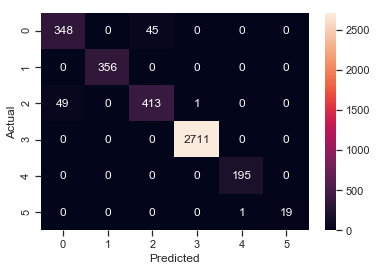

In [68]:
generate_confusion_matrix()

### Save/Load model

In [59]:
SAVE_MODEL = True
if SAVE_MODEL:
    save_dict = {
        "model"  : net.state_dict(),
        "optim"  : optimizer.state_dict()
    }
    torch.save(save_dict, "test.pt")

In [60]:
LOAD_MODEL = False
if LOAD_MODEL:
    load_dict = torch.load("test.pt")
    model_dict = load_dict['model']
    optim_dict = load_dict['optim']
    
    cnn.load_state_dict(model_dict)
    optimizer.load_state_dict(optim_dict)